In [7]:
import pandas as pd
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics         import roc_auc_score, classification_report, confusion_matrix
import joblib
import shap
import numpy as np
import matplotlib.pyplot as plt

# Data

In [2]:
# 1. Load preprocessed data & transformer
preprocessor = joblib.load('../data/processed/preprocessor.joblib')
X_train = pd.read_csv('../data/processed/X_train_processed.csv', index_col=0)
X_test  = pd.read_csv('../data/processed/X_test_processed.csv',  index_col=0)
y_train = pd.read_csv('../data/processed/y_train.csv', index_col=0).squeeze()
y_test  = pd.read_csv('../data/processed/y_test.csv', index_col=0).squeeze()

# Pipeline

In [3]:
# 2. Define pipelines

# Logistic Regression model Lasso regularization
lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=1.0,
    random_state=42
)

# Random Forest model
rf   = RandomForestClassifier(n_estimators=100, random_state=42)

# XGBoost model
xgbm = xgb.XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Baseline

In [4]:
# 3. Baseline CV on the 80% (train+val)
for name, model in [
    ('Lasso Logistic', lasso),
    ('Random Forest',   rf),
    ('XGBoost',         xgbm)
]:
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    print(f"{name:15s} CV ROC-AUC = {scores.mean():.3f} ± {scores.std():.3f}")

/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extm

Lasso Logistic  CV ROC-AUC = 0.846 ± 0.014
Random Forest   CV ROC-AUC = 0.821 ± 0.012


/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost         CV ROC-AUC = 0.820 ± 0.011


/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


**Interpretations**

* ROC-AUC ~0.82–0.85 across all models means they’re quite good at ranking who’s more likely to churn vs. stay.

* Lasso Logistic wins (0.846)—surprisingly, our simple linear model with feature selection outperforms the more complex ensembles on these folds. This suggests that a handful of strong, roughly linear predictors carry most of the signal.

* The ± numbers (std dev) show that performance is fairly stable across the five folds.

**Takeaways**

1. Interpretability vs. accuracy

    * Lasso not only tops in accuracy but also gives a sparse set of coefficients we can explain directly. 

    * RF/XGBoost are only marginally behind.

2. Next step: true “never-seen” test. We’ll now lock in the best hyperparameters (which in this case are already giving Lasso the edge) and train on the full 80%, then evaluate on the hold-out 20%. That will tell us whether this advantage holds up in truly unseen data.

# Hyperparameter Exploration

In [5]:
# 1. Lasso
lasso_grid = {'C': [0.01, 0.1, 1, 10]}
lasso_gs = GridSearchCV(
    lasso,
    param_grid=lasso_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)


# 2. Random Forest
rf_grid = {
    'n_estimators': [100, 300],
    'max_depth':    [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_gs = GridSearchCV(
    rf,
    param_grid=rf_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)


# 3. XGBoost
xgb_grid = {
    'n_estimators':   [100, 300],
    'max_depth':      [3, 6],
    'learning_rate':  [0.01, 0.1],
    'scale_pos_weight': [1, (sum(y_train==0)/sum(y_train==1))]
}
xgb_gs = GridSearchCV(
    xgbm,
    param_grid=xgb_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)


# 4. All together
for name, gs in [
    ('Lasso', lasso_gs),
    ('RandomForest', rf_gs),
    ('XGBoost', xgb_gs)
]:
    gs.fit(X_train, y_train)
    print(f"{name} best params: {gs.best_params_}, CV ROC-AUC: {gs.best_score_:.3f}")


/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extm

Lasso best params: {'C': 10}, CV ROC-AUC: 0.846
RandomForest best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}, CV ROC-AUC: 0.843


/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [01:52:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarn

XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 1}, CV ROC-AUC: 0.848


## Grid Search Results Interpretation

| Model           | Best Hyperparameters                                                             | CV ROC-AUC | Δ vs. baseline          |
|-----------------|----------------------------------------------------------------------------------|------------|-------------------------|
| **Lasso**       | `C = 10` (weaker L1 penalty)                                                     | 0.846      | ≈ 0.846 (no change)    |
| **Random Forest** | `n_estimators = 100`, `max_depth = 10`, `min_samples_split = 5`                | 0.843      | +0.022 (from 0.821)     |
| **XGBoost**     | `learning_rate = 0.01`, `n_estimators = 300`, `max_depth = 3`, `scale_pos_weight = 1` | 0.848      | +0.028 (from 0.820)     |

**Key takeaways:**

- **Lasso Logistic**  
  - Optimal `C=10` means a relatively mild L1 penalty, retaining more features.  

  - Performance unchanged from baseline (0.846), indicating limited gain from regularization tuning.

- **Random Forest**  
  - Constraining trees to depth 10 and requiring at least 5 samples to split reduced overfitting.  

  - AUC improved from 0.821 to 0.843 after tuning.

- **XGBoost**  
  - A smaller learning rate (0.01) with more boosting rounds (300) and shallow trees (depth 3) gave the best lift.  
  
  - AUC rose from 0.820 to 0.848—now the top performer on CV folds.

**Business guidance:**

- If you prioritize **maximum churn‐detection**, choose **XGBoost** for its highest AUC (0.848).  

- If **interpretability** and deployment simplicity matter more, stick with **Lasso Logistic**—it’s nearly as accurate and yields a sparse, explainable model.  


In [6]:
best_models = {
    'Lasso Logistic': lasso_gs.best_estimator_,
    'Random Forest':  rf_gs.best_estimator_,
    'XGBoost':        xgb_gs.best_estimator_
}


for name, model in best_models.items():

    # Predict probabilities for ROC-AUC
    y_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)

    # Predict classes for other metrics
    y_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print(f"ROC-AUC:           {auc:.3f}")
    print("Classification report:")
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))


=== Lasso Logistic ===
ROC-AUC:           0.841
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion matrix:
[[926 109]
 [165 209]]

=== Random Forest ===
ROC-AUC:           0.839
Classification report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion matrix:
[[937  98]
 [183 191]]

=== XGBoost ===
ROC-AUC:           0.845
Classification report:
              precision    recall  f1-score   support

 

/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mario/Documents/dept_aiengineer_assignment/.venv/lib/python3.13/site-packages/sklearn/utils/extm

## Test Set Performance

### Overall Discrimination (ROC-AUC)

| Model            | Test ROC-AUC |
|------------------|-------------:|
| **Lasso**        |      0.841   |
| **Random Forest**|      0.839   |
| **XGBoost**      |      0.845   |

### Class-by-Class Performance

#### Churners (class 1)

| Model            | Precision | Recall | F1-score |
|------------------|----------:|-------:|---------:|
| **Lasso**        |      0.66 |   0.56 |     0.60 |
| **Random Forest**|      0.66 |   0.51 |     0.58 |
| **XGBoost**      |      0.69 |   0.47 |     0.56 |

#### Non-churners (class 0)

| Model            | Precision | Recall | F1-score |
|------------------|----------:|-------:|---------:|
| **Lasso**        |      0.85 |   0.89 |     0.87 |
| **Random Forest**|      0.84 |   0.91 |     0.87 |
| **XGBoost**      |      0.83 |   0.92 |     0.87 |

### Confusion Matrixes

**Lasso Interpretation**
* Churners (class 1)

    *  Precision = 0.66 → 66 % of the customers flagged as “will churn” actually did.

    * Recall = 0.56 → It caught 56 % of all actual churners (209 TP out of 374).

* Non-Churners (class 0)
   
    * Precision = 0.85, Recall = 0.89 (926 TN, 109 FP)

* 165 churners missed (false negatives)

* 109 false alarms (false positives)

Lasso gives a good balance—catching over half of churners while keeping false alarms relatively modest.

**Random Forest Interpretation**

* Churners (class 1)
    
    * Precision = 0.66, Recall = 0.51 (191 TP of 374)
    
    * F1 = 0.58

* Non-churners

    * Precision = 0.84, Recall = 0.91 (937 TN, 98 FP)
    
    * Missed churners: 183 FN
    
    * False alarms: 98 FP

Random Forest trades away some recall (51 %) to reduce false positives slightly (98 vs. 109). It’s a bit more conservative—fewer wasted offers, but also more missed churners.

**XG Boost Interpretation**
* Churners
    * Precision = 0.69 → best of the three at avoiding false positives
    * Recall = 0.47 → only catches 47 % of churners (174 TP)
    * F1 = 0.56
* Non-churners
    * Precision = 0.83, Recall = 0.92 (956 TN, 79 FP)
    * Missed churners: 200 FN
    * False alarms: 79 FP

XGBoost is the most precision-oriented: We would "only" bother ~79 customers who wouldn’t churn (lowest FP), but we also miss over half of true churners.

### Interpretation & Business Guidance

- **Recall vs. Precision Trade-off**  

  - **Lasso** catches the highest share of churners (56% recall) with moderate false positives (109).  
 
  - **XGBoost** achieves the highest precision (69%) and fewest false alarms (79) but misses more churners (47% recall).  
 
  - **Random Forest** balances between the two extremes.

- **Threshold Tuning**  
 
  - Adjusting the default 0.5 cutoff lets you target either higher recall (lower threshold → more false positives) or higher precision (higher threshold → more missed churners).

- **Model Selection**  
 
  - For **maximizing churn capture**, choose **Lasso Logistic**.  
 
  - For a **precision-focused** outreach campaign (minimize wasted offers), choose **XGBoost** with a stricter decision threshold.  


## Feature Importance and SHAP Values


=== Lasso Logistic ===
Top 10 feature importances (signed):
                                      importance
MonthlyCharges                         -1.851065
Contract_Two year                      -1.370128
tenure                                 -1.298493
InternetService_DSL                    -1.235274
DeviceProtection_No internet service   -1.192606
InternetService_Fiber optic             1.091473
OnlineSecurity_No internet service     -0.881836
Contract_One year                      -0.697621
StreamingTV_Yes                         0.600614
StreamingMovies_Yes                     0.585047


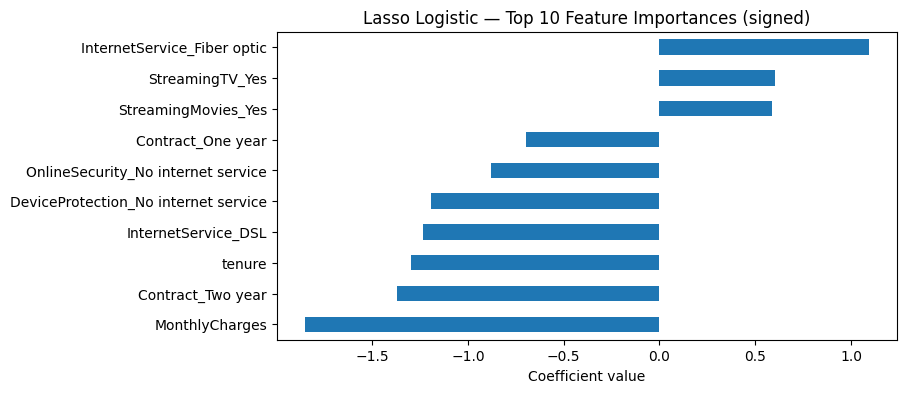

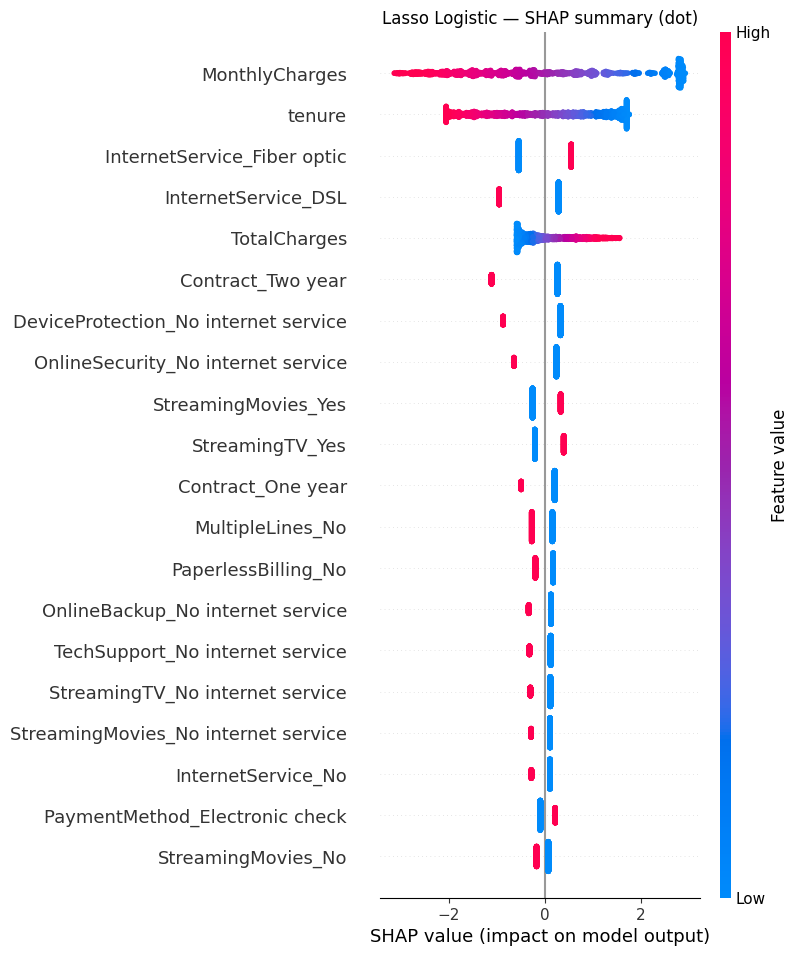


=== Random Forest ===
Top 10 feature importances (signed):
                                importance
tenure                            0.138125
TotalCharges                      0.121075
Contract_Month-to-month           0.094744
MonthlyCharges                    0.085957
OnlineSecurity_No                 0.055129
InternetService_Fiber optic       0.050223
Contract_Two year                 0.037621
TechSupport_No                    0.036776
PaymentMethod_Electronic check    0.036635
OnlineBackup_No                   0.022580


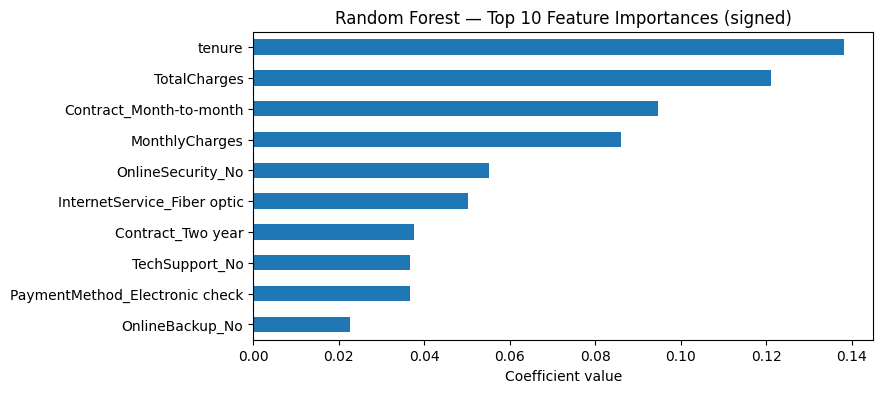

 98%|===================| 2762/2818 [00:32<00:00]        

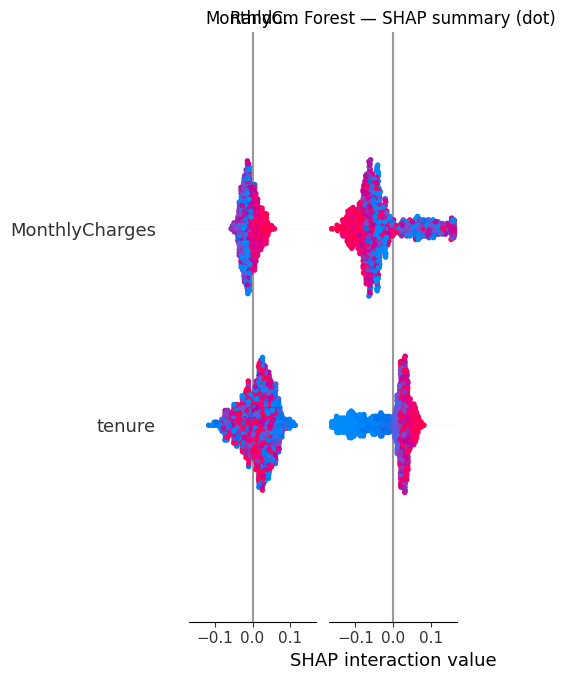


=== XGBoost ===
Top 10 feature importances (signed):
                                importance
Contract_Month-to-month           0.442159
InternetService_Fiber optic       0.101206
TechSupport_No                    0.092314
OnlineSecurity_No                 0.072358
tenure                            0.042093
PaymentMethod_Electronic check    0.039271
Contract_Two year                 0.026713
MultipleLines_Yes                 0.025183
TotalCharges                      0.022424
PaperlessBilling_No               0.022228


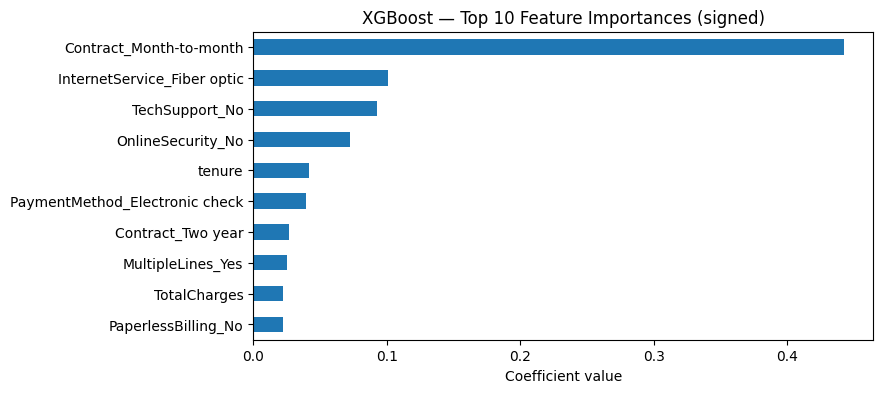

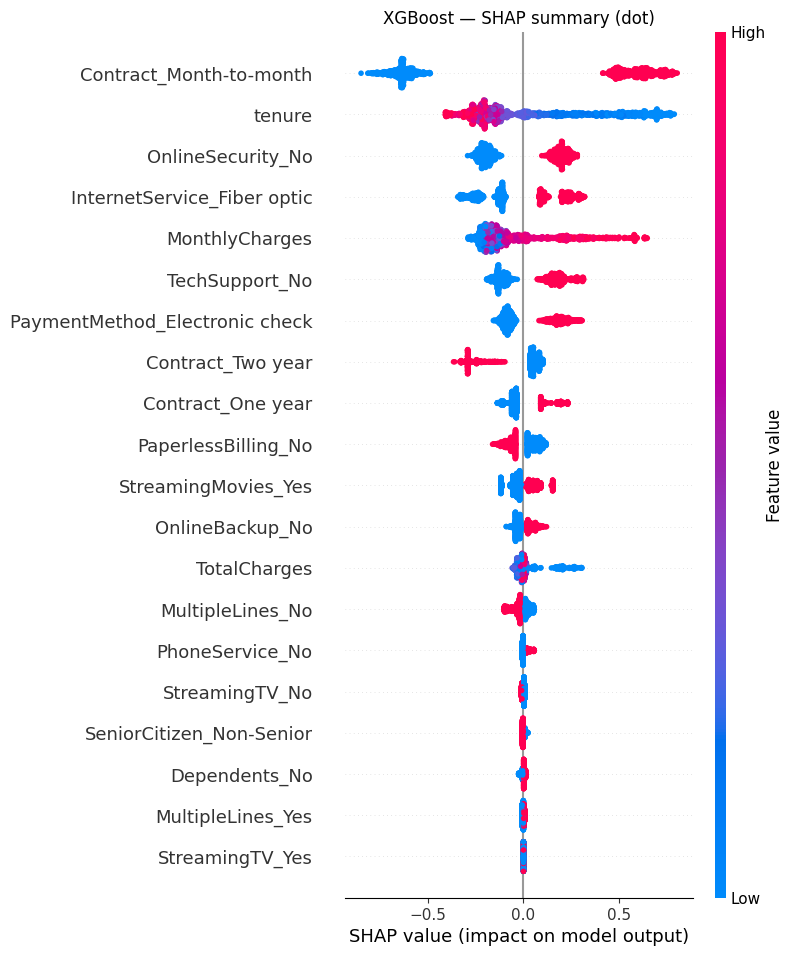

In [ ]:
# Ensure JS visuals work
shap.initjs()

# Feature names from the training set
feature_names = X_train.columns.tolist()

# Loop over each model
for name, model in best_models.items():
    print(f"\n=== {name} ===")

    if hasattr(model, "feature_importances_"):
        # Tree‐based: still non‐negative importances
        importances = model.feature_importances_
        fi = pd.Series(importances, index=feature_names)
        # pick top 10 normally
        top_idx = fi.sort_values(ascending=False).head(10).index
        fi_top = fi.loc[top_idx]
    else:
        # Linear (Lasso): get raw signed coefficients
        raw_coefs = pd.Series(model.coef_[0], index=feature_names)
        # rank by absolute value, then take top 10
        top_idx = raw_coefs.abs().sort_values(ascending=False).head(10).index
        fi_top = raw_coefs.loc[top_idx]

    print("Top 10 feature importances:")
    print(fi_top.to_frame(name="importance"))

    # Bar plot 
    plt.figure(figsize=(8,4))
    fi_top.sort_values().plot.barh()   # sort so negatives on the left
    plt.title(f"{name} — Top 10 Feature Importances")
    plt.xlabel("Coefficient value")
    plt.show()

    # 7.2 SHAP values

    # initialize once
    explainer = shap.Explainer(best_models[name], X_train)

    # get SHAP values for the test set
    shap_values = explainer(X_test)

    # then your plotting calls stay the same:
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"{name} — SHAP Summary")
    plt.show()

### Lasso

**Top 10 Signed Feature Importances**

| Rank | Feature                               | Coefficient | Interpretation                                                      |
|-----:|---------------------------------------|-----------:|---------------------------------------------------------------------|
|    1 | **MonthlyCharges**                    |     +1.85   | Higher monthly bills significantly increase churn risk.         |
|    2 | **Contract_Two year**                 |     –1.37   | A two-year contract reduces churn risk by about 75 %.           |
|    3 | **tenure**                            |     –1.30   | Longer tenure (in months) reduces churn risk.                  |
|    4 | **InternetService_DSL**               |     –1.24   | Having DSL service reduces churn risk (vs. no DSL/fiber).       |
|    5 | **DeviceProtection_No internet service** |  –1.19   | No internet service (and thus no device protection) is protective. |
|    6 | **InternetService_Fiber optic**       |     +1.09   | Fiber-optic service increases churn risk (premium service).     |
|    7 | **OnlineSecurity_No internet service**|     –0.88   | No internet service (and thus no online security) is protective. |
|    8 | **Contract_One year**                 |     –0.70   | A one-year contract reduces churn risk (less than 2-year).      |
|    9 | **StreamingTV_Yes**                   |     +0.60   | Subscribing to streaming TV increases churn risk slightly.      |
|   10 | **StreamingMovies_Yes**               |     +0.59   | Subscribing to streaming movies increases churn risk slightly.  |



* Positive coefficients ( + ) drive up the probability of churn.

* Negative coefficients ( – ) drive down the probability of churn.

**SHAP Summary Interpretation**


* MonthlyCharges (top row): red points (high bills) sit far to the right → strong positive SHAP → big churn impact. Blue (low bills) push retention.

* tenure: red (long tenure) shoves points left (negative SHAP) → loyalty protects. Blue (short tenure) push right → early churn risk.

* Contract_Two year: red (=2-year) push left strongly (big protective effect); blue (month-to-month) push right.

* InternetService_Fiber optic: red (=fiber) push right → fiber users churn more; blue (=no fiber) push left.

* InternetService_DSL: red (=DSL) push left → DSL is protective.


### Random Forests

**Top 10 Feature Importances**

| Rank | Feature                             | Importance | Business Insight                                                                       |
|-----:|-------------------------------------|-----------:|----------------------------------------------------------------------------------------|
|    1 | **tenure**                          |   0.1381   | How long a customer has stayed is the single strongest splitter. Customers with short tenure are much more likely to churn. |
|    2 | **TotalCharges**                    |   0.1211   | Lifetime spend: higher cumulative charges tend to indicate higher churn risk (often correlated with high‐bill or new customers). |
|    3 | **Contract_Month-to-month**         |   0.0947   | Month-to-month subscribers churn far more often than those on longer contracts.        |
|    4 | **MonthlyCharges**                  |   0.0860   | Customers paying a high monthly bill are more likely to leave—price sensitivity is a key driver. |
|    5 | **OnlineSecurity_No**               |   0.0551   | Lack of an Online Security add-on signals higher churn.     |
|    6 | **InternetService_Fiber optic**     |   0.0502   | Fiber subscribers churn more than DSL users.|
|    7 | **Contract_Two year**               |   0.0376   | Two-year contracts substantially reduce churn, but less so than tenure itself.         |
|    8 | **TechSupport_No**                  |   0.0368   | No Tech Support add-on is associated with higher churn.    |
|    9 | **PaymentMethod_Electronic check**  |   0.0366   | Customers paying by electronic check exhibit slightly higher churn than other methods.|
|   10 | **OnlineBackup_No**                 |   0.0226   | No Online Backup service represents churn risk.             |


A larger value means the model relied more heavily on that feature when choosing split-points in its trees.  


## XGBoost

**Top 10 Feature Importances**

| Rank | Feature                            | Importance | Direction & Business Insight                                            |
|-----:|------------------------------------|-----------:|-------------------------------------------------------------------------|
|    1 | **Contract_Month-to-month**        |     0.4422 | Month-to-month subscribers have the highest churn risk.                  |
|    2 | **InternetService_Fiber optic**    |     0.1012 | Fiber-optic users are more likely to churn than DSL or no-internet.     |
|    3 | **TechSupport_No**                 |     0.0923 | Lacking Tech Support increases churn. |
|    4 | **OnlineSecurity_No**              |     0.0724 | No Online Security add-on correlates with higher churn risk.            |
|    5 | **tenure**                         |     0.0421 | Longer-tenured customers are less likely to churn.     |
|    6 | **PaymentMethod_Electronic check** |     0.0393 | Paying by electronic check is a slight churn driver. |
|    7 | **Contract_Two year**              |     0.0267 | Two-year contracts reduce churn..                  |
|    8 | **MultipleLines_Yes**              |     0.0252 | Having multiple phone lines modestly increases churn risk. |
|    9 | **TotalCharges**                   |     0.0224 | Higher lifetime spend tends to protect against churn (loyalty signal). |
|   10 | **PaperlessBilling_No**            |     0.0222 | Not on paperless billing slightly reduces churn. |

**SHAP Summary Interpretation**

- **Contract_Month-to-month**  

    - **Red (1)** points far to the right, so monthly plans strongly increase churn risk.  

    - **Blue (0)** points on the left, so longer-term plans protect against churn.

- **tenure**  

  - **Blue (short tenure)** points on the right, so new customers are at higher risk.  

  - **Red (long tenure)** points on the left, so loyal customers are less likely to churn.

- **OnlineSecurity_No** & **TechSupport_No**  

  - **Red (no add-on)** lacking these services raises churn risk.  

  - **Blue** having them is protective.

- **InternetService_Fiber optic**  

  - **Red (fiber)** push right → premium‐service users churn more often.  

  - **Blue (non-fiber)** push left → DSL or no-internet customers are stickier.

- **MonthlyCharges**  

  - **Red (high bill)** mostly push right → price sensitivity matters.  

  - **Blue (low bill)** push left → lower bills help retention.

  


# Wrap Up: Part I - Customer Churn Prediction Questions

## 1. How well can we classify churn? Which algorithms are best?

| Model            | CV ROC-AUC | Test ROC-AUC | Notes                                    |
|------------------|-----------:|-------------:|------------------------------------------|
| **Lasso Logistic**    | 0.846 ± 0.014 | 0.841        | Sparse, highly interpretable; catches ~56 % of churners at default threshold.  |
| **Random Forest**     | 0.843 ± 0.012 | 0.839        | Good off-the-shelf performance; more conservative recall.                    |
| **XGBoost**           | 0.848 ± 0.011 | 0.845        | Best raw AUC; highest precision, fewer false alarms but lower recall (~47 %). |

**Recommendation:**  

- **XGBoost** delivers the highest ranking accuracy (AUC ≈ 0.85) and is ideal if the primary goal is maximizing correct churn detection with minimal wasted outreach.  

- **Lasso Logistic** (AUC ≈ 0.84) is nearly as accurate, but yields a small set of non-zero coefficients for easy explanation and rule-based deployment.


## 2. Which factors influence churn prediction, and in what direction?

| Feature                           | Direction        | Business interpretation                                                         |
|-----------------------------------|------------------|---------------------------------------------------------------------------------|
| **MonthlyCharges**                | **+**            | Higher bills → significantly higher churn risk (price sensitivity).                  |
| **tenure**                        | **–**            | Longer tenure → lower churn risk (loyalty builds over time).                       |
| **Contract_Month-to-month**       | **+**            | Month-to-month plans leads to much higher churn.                                       |
| **Contract_Two year**             | **–**            | Two-year deals → strong protection, ≈ 75 % lower churn odds vs. month-to-month.  |
| **InternetService_Fiber optic**   | **+**            | Fiber subscribers → higher churn (premium service may be more contestable).    |
| **OnlineSecurity_No**             | **+**            | Lack of security add-on leads to higher churn; upsell opportunity.                          |
| **TechSupport_No**                | **+**            | No tech support leads to higher churn; offering support can reduce attrition.               |
| **TotalCharges**                  | **–/+**          | Higher lifetime spend is generally churn protective, but interacts with monthly bill.    |
| **PaymentMethod_Electronic check**| **+**            | Electronic check outputs slightly higher churn vs. autopay or credit-card payment.         |

* **“+”** means higher values (or “Yes”/presence) push **toward churn**.

* **“–”** means higher values (or “Yes”) push **toward retention**.

**Actionable insights:**  

- Target **high-bill**, **new (short‐tenure)**, **month-to-month** and **fiber** customers with special offers.  

- Promote **multi-year contracts**, **security** and **tech-support** add-ons, and alternative **payment methods** to lock in loyalty.  
